In [9]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align
from redcross.planet import Planet

c = 2.99e5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

orders = [48, 49]
dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(orders)

apply_wavesol = False
if apply_wavesol:
    wavesol = []
    for i,o in enumerate(orders):
        dco = dc.order(i)
        wavesol.append(np.loadtxt(data_dir+'../wavesol_order{:}.dat'.format(o)))
        dco.common_wave_grid(wavesol[i])
        dc.flux[i,:] = dco.flux

    dc.wlt = np.array(wavesol)
else:
    dc.wlt = np.median(dc.wlt, axis=1) # define wavelength solution for each order as its time average

dc.flux_err[dc.flux_err==0.] = np.nan


Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy


In [11]:
planet = Planet('wasp189', **dc.get_header().header)
# Get eclipse mask
# ecl = planet.mask_eclipse(return_mask=True)
species = 'CO_main_iso'
species_name = species.split('_')[0]
template_path = 'data/template_giano_{:}_2500K.npy'.format(species)
twave, tflux = np.load(template_path)

# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux).high_pass_gaussian(window=15)

Reducing order...
1. remove_continuum
2. sigma_clip
3. mask_cols 
--Exit at iteration 1--
--> 11.33 % of pixels masked
4. airmass_detrend
5. mask_cols 
--> 2.05 % of pixels masked
--> 1.46 % of pixels masked
6. sysrem    
Convergence at iteration  14 --- StDev = 0.0225
Convergence at iteration 107 --- StDev = 0.0220
Convergence at iteration  10 --- StDev = 0.0214
Convergence at iteration  22 --- StDev = 0.0209
Convergence at iteration  49 --- StDev = 0.0204
Convergence at iteration 632 --- StDev = 0.0200
Convergence at iteration  17 --- StDev = 0.0196
Convergence at iteration  81 --- StDev = 0.0192
Convergence at iteration  36 --- StDev = 0.0188
7. high_pass_gaussian
8. sigma_clip
9. mask_cols 
----18.16 % of pixels have been masked----


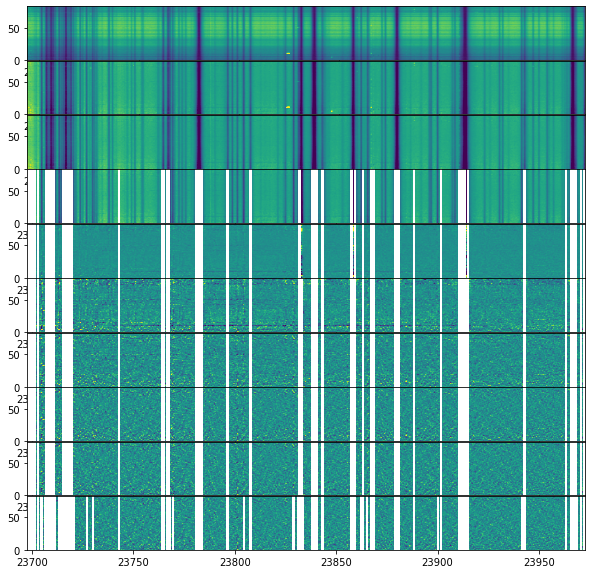

In [15]:
pipe = Pipeline(steps=[])     
pipe.add('remove_continuum', {'mode':'polyfit'})
pipe.add('sigma_clip')
# pipe.add('inject_signal', {'factor':60., 'planet':planet, 'template':template})
pipe.add('mask_cols', {'sigma':1.2, 'mode':'flux', 'debug':True})

pipe.add('airmass_detrend')
# pipe.add('mask_cols', {'sigma':1.2, 'mode':'flux', 'debug':True})
pipe.add('mask_cols', {'sigma':2.5, 'mode':'flux_err', 'cycles':2, 'debug':True})
pipe.add('sysrem', {'n':9, 'debug':True})
pipe.add('high_pass_gaussian', {'window':15})
pipe.add('sigma_clip', {'sigma':3.})
pipe.add('mask_cols', {'sigma':3., 'cycles':2, 'mode':'flux_err'})

n = len(pipe.steps) + 1
dco = dc.split_orders(debug=False).order(2) # split order in two sections (flux jump) and select a half-order to work with
fig, ax = plt.subplots(n,1, figsize=(10,1.*n))
plt.subplots_adjust(hspace=0.01)

dco = pipe.reduce(dco, ax=ax)
print('----{:.2f} % of pixels have been masked----'.format(100*dco.nan_frac))


In [13]:
dcs = dc.split_orders(debug=False)

wave, flux, flux_err = ([] for _ in range (3)) 
for order in range(4):
    dco = dcs.order(order) # split order in two sections (flux jump) and select a half-order to work with
    dco = pipe.reduce(dco)
    
#     dcs.wlt[order,:] = dco.wlt
#     dcs.flux[order,:,:] = dco.flux
#     dcs.flux_err[order,:,:] = dco.flux_err
    wave.append(dco.wlt)
    flux.append(dco.flux)
    flux_err.append(dco.flux_err)
    
dcm = Datacube(flux=np.hstack(flux), wlt=np.hstack(wave), flux_err=np.hstack(flux_err))
# dcm = Datacube(wlt=np.hstack(dcs.wlt), flux=np.hstack(dcs.flux), flux_err=np.hstack(dcs.flux_err))
nans = np.isnan(dcm.wlt)
frac_masked = nans[nans==True].size / nans.size
print('{:.2f} % of pixels have been masked'.format(100*frac_masked))

#   Apply BERV correction (shift each frame)
# dcm.to_stellar_frame(-dcs.BERV) 
# As with HARPSN, we are essentially taking the median BERV shift 
# beta = 1 - np.median(dc.BERV)/c
# dcm.wlt *= beta

Reducing order...
1. remove_continuum
2. sigma_clip
3. airmass_detrend
4. mask_cols 
5. mask_cols 
6. sysrem    


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


7. high_pass_gaussian
8. sigma_clip
9. mask_cols 
10. remove_continuum
11. sigma_clip
12. mask_cols 
--> 8.69 % of pixels masked
13. airmass_detrend
14. mask_cols 
--> 1.07 % of pixels masked
--> 2.64 % of pixels masked
15. sysrem    
Convergence at iteration 304 --- StDev = 72.4616
Convergence at iteration  36 --- StDev = 72.4622
Convergence at iteration  37 --- StDev = 72.4365
Convergence at iteration  29 --- StDev = 72.4172
Convergence at iteration  83 --- StDev = 72.4228
Convergence at iteration  60 --- StDev = 72.4164
Convergence at iteration  83 --- StDev = 72.4183
Convergence at iteration 109 --- StDev = 72.4195
Convergence at iteration  77 --- StDev = 72.4417
16. high_pass_gaussian
17. sigma_clip
18. mask_cols 
Reducing order...
1. remove_continuum
2. sigma_clip
3. airmass_detrend
4. mask_cols 
5. mask_cols 
6. sysrem    
7. high_pass_gaussian
8. sigma_clip
9. mask_cols 
10. remove_continuum
11. sigma_clip
12. mask_cols 
--> 2.64 % of pixels masked
13. airmass_detrend
14. mask_

/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/datacube.py:185: RuntimeWarning: Mean of empty slice
  mean, std = np.nanmean(flux[:,x]), np.nanstd(flux[:,x])


9. mask_cols 
10. remove_continuum

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/datacube.py:264: RuntimeWarning: Mean of empty slice
  mean, std = np.nanmean(y), np.nanstd(y)


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
# Define parameters for cross-correlation and Kp-Vsys map
hpw = 15
dRV = 2.7
# dRV = 1.5
RVt = np.arange(-350,351, dRV)
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
v_range = [-4.,7.0] # fix color scale

template = Template(wlt=twave, flux=tflux).high_pass_gaussian(window=hpw)
# template = Template(wlt=twave, flux=tflux)

In [ ]:
# Run CCF and KpV
ccf = CCF(rv=RVt, template=template).run(dcm, weighted=True)
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)

kpv.run().fancy_figure(peak=[2.7,195], v_range=v_range)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,3))

print('{:.2f} % of pixels have been masked'.format(100*dcm.nan_frac))
dcm.imshow()